In [2]:
import numpy as np
import scipy as sp
import qibo
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm



In [3]:
def createPauliString(nsites, position, symbols):
    pauliString = ""
    for i in range(nsites):
        if i not in position:
            pauliString += "I"
        else:
            pauliString += symbols[position.index(i)]

    return pauliString

def pauliStr2Matrix(str):
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    if str[0] == 'I':
        mat = I
    elif str[0] == 'X':
        mat = X
    elif str[0] == 'Y':
        mat = Y
    elif str[0] == 'Z':
        mat = Z

    for i in range(len(str)-1):
        if str[i+1] == 'I':
            mat = np.kron(mat, I)
        elif str[i+1] == 'X':
            mat = np.kron(mat, X)
        elif str[i+1] == 'Y':
            mat = np.kron(mat, Y)
        elif str[i+1] == 'Z':
            mat = np.kron(mat, Z)
    
    return mat

def number2Spin(nsites, number):
    spin = np.empty(nsites, dtype=object)
    binary = format(number, f'0{nsites}b')
    for i in range(nsites):
        if binary[i] == '0':
            spin[i] = "up"
        else:
            spin[i] = "down"
    return spin

def thermalState(beta, H):
    rho = sp.linalg.expm(-beta * H)
    rho = rho / np.trace(rho)
    return rho

def computeExpectationValue(rho, operator):
    return np.real(np.trace(rho@operator))

def computeExpectationValueState(state, operator):
    return np.real(np.vdot(state, operator@state))



In [4]:
def jordan_wigner_tfim(n_sites, Jx=1.0, Jy=1.0, h=1.0):
    """
    Construct the Bogoliubov-de Gennes matrix for  Ising model:

    Args:
        n_sites (int): Number of sites
        Jx (float): Coupling strength for σ^x σ^x interaction
        Jy (float): Coupling strength for σ^y σ^y interaction
        h (float): Transverse field strength

    Returns:
        numpy.ndarray: 2n_sites × 2n_sites BdG matrix
    """
    J = Jx + Jy
    k = (Jx - Jy) / J
    A = np.zeros((n_sites, n_sites))
    B = np.zeros((n_sites, n_sites))

    for i in range(n_sites-1):
        A[i, i] = h
        A[i+1, i+1] = h

    # The X terms become nearest-neighbor hopping
    for i in range(n_sites-1):
        A[i, i+1] = A[i+1, i] = -J/2


    for i in range(n_sites-1):
        B[i, i+1] = -J*k/2
        B[i+1, i] = J*k/2

    # Construct BdG matrix
    M = np.block([
        [A, B],
        [-B, -A]
    ])

    return M

def diagonalize_bdg_matrix(M):
    """
    Diagonalize the Bogoliubov-de Gennes matrix to find single-particle energies.
    """
    # Diagonalize the BdG matrix
    eigenvalues, eigenvectors = np.linalg.eigh(M)

    # The eigenvalues come in pairs (ε, -ε)
    # We only need the positive ones for the fermionic spectrum
    n = len(eigenvalues) // 2
    energies = eigenvalues[n:]  # Take the positive eigenvalues

    return energies, eigenvectors

def fermi_dirac(E, beta):
    return 1 / (1 + np.exp(beta * E))


In [5]:
def zz_correlation(M, beta, i, j):
    N = M.shape[0] // 2
    eigvals, eigvecs = np.linalg.eigh(M)

    f = 1 / (np.exp(2*beta * eigvals) + 1)  
    f_diag = np.diag(f)

    Uk = eigvecs[:N, :]
    Vk = eigvecs[N:, :]

    G = Uk @ f_diag @ Uk.T
    F = Uk @ f_diag @ Vk.T

    zz = 4*(G[i,i]-0.5)*(G[j,j]-0.5) - 4*G[i,j]*G[j,i] + 4*np.abs(F[i,j])**2

    return zz


[Qibo 0.2.17|INFO|2025-04-29 13:32:48]: Using numpy backend on /CPU:0
[Qibo 0.2.17|WARNING|2025-04-29 13:32:48]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


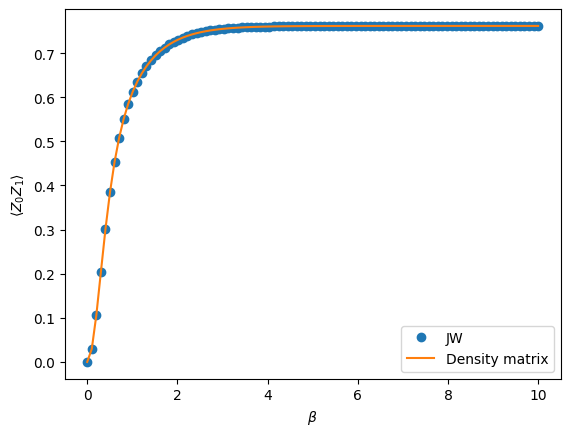

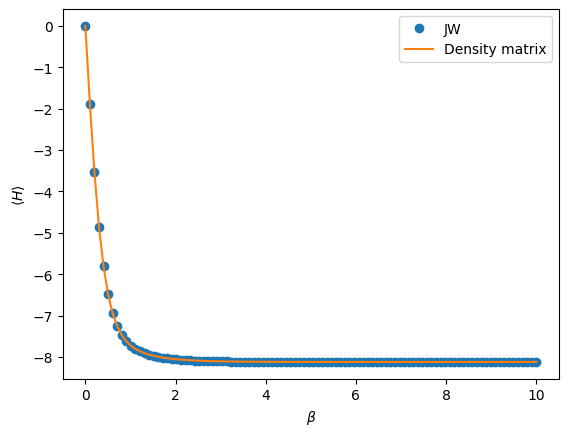

In [6]:
nqubits = 4
# J = 1.0
# h = 1.0
# H_def = sum([-J*X(x)*X(x+1) - h*Z(x) for x in range(nqubits-1)])  - h*Z(nqubits-1)
# H = hamiltonians.SymbolicHamiltonian(H_def).matrix

Jx = -1.0
Jy = 2.0
h = 1.0
H_def = sum([-Jx*X(x)*X(x+1)-Jy*Y(x)*Y(x+1) - h*Z(x) for x in range(nqubits-1)]) - h*Z(nqubits-1) 
H = hamiltonians.SymbolicHamiltonian(H_def).matrix


beta = np.linspace(0, 10, 100)
expectations = np.zeros(len(beta))
energy_rho = np.zeros(len(beta))

for i in range(len(beta)):
    rho = thermalState(beta[i], H)
    operator = pauliStr2Matrix(createPauliString(nqubits, [0,1], ['Z','Z']))
    expectations[i] = computeExpectationValue(rho, operator)
    energy_rho[i] = computeExpectationValue(rho, H)

nSites = nqubits


M = jordan_wigner_tfim(nSites, Jx, Jy, h)

energies, eigenvectors = diagonalize_bdg_matrix(M) 

corr = np.zeros(len(beta))
energy = np.zeros(len(beta))
for i in range(len(beta)):
    corr[i] = zz_correlation(M, beta[i], 0, 1)
    n_k = fermi_dirac(energies, 2*beta[i])
    energy[i] = np.sum(energies * (2*n_k-1))
plt.figure()
plt.plot(beta, corr, 'o', label = 'JW')
plt.plot(beta, expectations, label = 'Density matrix')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle Z_{0} Z_{1} \rangle$')
plt.legend()

plt.figure()
plt.plot(beta, energy, 'o' , label = 'JW')
plt.plot(beta, energy_rho , label = 'Density matrix')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle H \rangle$')
plt.legend()
plt.show()



In [7]:
def exactSeriesExpansion(N, H, order, beta):
    Z = 0
    for i in range(0,order+1):
        Z += ((-1)**i*(beta)**i/sp.special.factorial(i))*np.trace(np.linalg.matrix_power(H, i))
    return Z

def expectationSeries(O, H, beta, order):
    E = 0
    for i in range(0,order+1):
        E += ((-1)**i*(beta)**i/sp.special.factorial(i))*np.trace(np.linalg.matrix_power(H, i)@O)
    return E


[Qibo 0.2.17|WARNING|2025-04-29 13:35:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-04-29 13:35:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-04-29 13:35:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-04-29 13:35:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


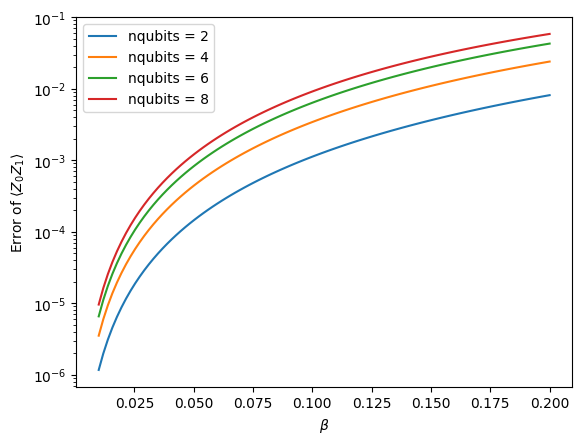

In [19]:
nqubits = [2,4,6,8]

plt.figure()
for nqubits in nqubits:

    H_def = sum([X(x)*X(x+1) + Y(x)*Y(x+1)+Z(x)*Z(x+1) for x in range(nqubits-1)])
    H = hamiltonians.SymbolicHamiltonian(H_def).matrix
    beta = np.linspace(0.01, 0.2, 100)
    Obs = pauliStr2Matrix(createPauliString(nqubits, [0,1], ['Z','Z']))

    expectationExact = np.zeros(len(beta))
    expectationApprox = np.zeros(len(beta))
    
    for i in range(len(beta)):
        rho = thermalState(beta[i], H)
        expectationExact[i] = computeExpectationValue(rho, Obs)
        expectationApprox[i] = (-beta[i]-beta[i]**2)/(1+3/2*beta[i]**2*(nqubits-1))

    plt.plot(beta, np.abs(expectationExact-expectationApprox), label = f'nqubits = {nqubits}')
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'Error of $\langle Z_{0} Z_{1} \rangle$')
    plt.yscale('log')
plt.legend()

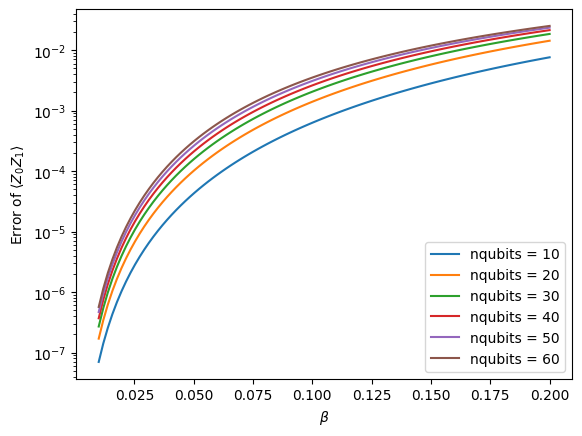

In [15]:
nqubits = [10, 20, 30, 40, 50, 60]
plt.figure()
Jx = 1.0
Jy = 1.0
h = 0.0
for nqubits in nqubits:

    beta = np.linspace(0.01, 0.2, 100)

    expectationExact = np.zeros(len(beta))
    expectationApprox = np.zeros(len(beta))
    M = jordan_wigner_tfim(nqubits, Jx, Jy, h)
    eigvals, eigvecs = np.linalg.eigh(M)
    for i in range(len(beta)):
        expectationExact[i] = zz_correlation(M, beta[i], 5, 6)
        expectationApprox[i] = (-beta[i]**2)/(1+ beta[i]**2*(nqubits-1))

    plt.plot(beta, np.abs(expectationExact-expectationApprox), label = f'nqubits = {nqubits}')
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'Error of $\langle Z_{0} Z_{1} \rangle$')
    plt.yscale('log')
plt.legend()